Defining the autoencoder module

In [21]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

# Constants and Configurations
your_path = r'/Users/elliotlindestam/Documents/Skola/Indek icloud/trioptima/'
folder_path = os.path.join(your_path, '6.Active Data/Train Model Data/')
LAYER_OPTIONS = [10]
NEURON_OPTIONS = [1000]
DECREASING_NEURONS = 50
MIN_NEURONS = 100
ENCODER_ACTIVATION_FUNCTIONS = ['relu']
DECODER_ACTIVATION_FUNCTIONS = ['linear']

INITIAL_VAL_LOSS = float('inf')  # Set initial value to infinity

def load_preprocessed_data(folder_path):
    # Get file in the folder
    files = [f for f in os.listdir(folder_path) if f != '.DS_Store']
    file_name = files[0][:-4]

    # Load preprocessed data
    file_path = os.path.join(your_path, '4.Scaled', file_name + '_Scaled.csv')
    data = pd.read_csv(file_path, header=0)

    # Convert data to float32
    data = data.astype(np.float32)

    # Check for inf or NaN values in data
    print("Inf values in data: ", np.isinf(data).values.sum())
    print("NaN values in data: ", np.isnan(data).values.sum())

    return data

def build_autoencoder(input_dim, starting_neurons, num_layers, decreasing_neurons, min_neurons, encoder_activation_fn, decoder_activation_fn):
    current_num_neurons = starting_neurons
    input_layer = layers.Input(shape=(input_dim,))
    encoder_layer = layers.Dense(current_num_neurons, activation=encoder_activation_fn)(input_layer)
    nodes_per_layer = [current_num_neurons]

    for _ in range(1, num_layers):
        current_num_neurons = max(min_neurons, current_num_neurons - decreasing_neurons)
        encoder_layer = layers.Dense(current_num_neurons, activation=encoder_activation_fn)(encoder_layer)
        nodes_per_layer.append(current_num_neurons)
    
    decoder_layer = layers.Dense(input_dim, activation=decoder_activation_fn)(encoder_layer)

    model = models.Model(inputs=input_layer, outputs=decoder_layer)
    return model, nodes_per_layer


def main():
    data_preprocessed = load_preprocessed_data(folder_path)

    # Ensure data is in expected format
    assert data_preprocessed.map(np.isreal).all().all(), "Non-numeric data found"
    assert not data_preprocessed.isnull().any().any(), "NaN values found"

    input_dim = data_preprocessed.shape[1]
    best_num_layers = None
    best_num_neurons = None
    best_weights = None
    best_val_loss = INITIAL_VAL_LOSS

    best_encoder_activation_fn = None
    best_decoder_activation_fn = None

    for encoder_activation_fn in ENCODER_ACTIVATION_FUNCTIONS:
        for decoder_activation_fn in DECODER_ACTIVATION_FUNCTIONS:
            for num_neurons in NEURON_OPTIONS:
                for num_layers in LAYER_OPTIONS:
                    K.clear_session()

                    temp_autoencoder, _ = build_autoencoder(input_dim, num_neurons, num_layers, DECREASING_NEURONS, MIN_NEURONS, encoder_activation_fn, decoder_activation_fn)
                    
                    temp_autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        
                    history = temp_autoencoder.fit(
                        data_preprocessed, data_preprocessed,
                        epochs=10, 
                        batch_size=32,
                        shuffle=True,
                        validation_split=0.1
                    )
        
                    final_val_loss = history.history['val_loss'][-1]
                    if final_val_loss < best_val_loss:
                        best_val_loss = final_val_loss
                        best_num_layers = num_layers
                        best_num_neurons = num_neurons
                        best_weights = temp_autoencoder.get_weights()
                        best_encoder_activation_fn = encoder_activation_fn
                        best_decoder_activation_fn = decoder_activation_fn


    # Construct the best model with configurations
    K.clear_session()
    autoencoder, nodes_per_layer = build_autoencoder(input_dim, best_num_neurons, best_num_layers, DECREASING_NEURONS, MIN_NEURONS, best_encoder_activation_fn, best_decoder_activation_fn)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.set_weights(best_weights)

    # Display the configuration of the best model
    print(f"Best Model Configuration:")
    print(f"Number of Layers: {best_num_layers}")
    print(f"Number of Neurons per Layer: {nodes_per_layer}")
    print(f"Encoder Activation Function: {best_encoder_activation_fn}")
    print(f"Decoder Activation Function: {best_decoder_activation_fn}")
    return autoencoder

if __name__ == "__main__":
    autoencoder = main()


Inf values in data:  0
NaN values in data:  0
Epoch 1/10
398/398 [==============================] - 34s 79ms/step - loss: 2029.3783 - val_loss: 2.1782
Epoch 2/10
398/398 [==============================] - 31s 78ms/step - loss: 19.1825 - val_loss: 2.5013
Epoch 3/10
398/398 [==============================] - 31s 78ms/step - loss: 37.1280 - val_loss: 29.1201
Epoch 4/10
398/398 [==============================] - 31s 77ms/step - loss: 67.2005 - val_loss: 33.4007
Epoch 5/10
398/398 [==============================] - 32s 80ms/step - loss: 52.5691 - val_loss: 11.0085
Epoch 6/10
398/398 [==============================] - 35s 87ms/step - loss: 46.2011 - val_loss: 3.6073
Epoch 7/10
398/398 [==============================] - 32s 80ms/step - loss: 50.3842 - val_loss: 56.9094
Epoch 8/10
398/398 [==============================] - 32s 80ms/step - loss: 50.6010 - val_loss: 179.4240
Epoch 9/10
398/398 [==============================] - 33s 82ms/step - loss: 43.2096 - val_loss: 418.6143
Epoch 10/10
398/3

Anomaly detection

In [22]:
test_folder_path = your_path + '6.Active Data/Test Data/'
train_folder_path = your_path + '6.Active Data/Train Model Data/'

# Get file in the folder
files = os.listdir(folder_path)

# MAC issue
files = [f for f in files if f != '.DS_Store']
file_name = files[0][:-4]

train_data_preprocessed = load_preprocessed_data(train_folder_path)
test_data_preprocessed = load_preprocessed_data(test_folder_path)
# Check to make sure the data is in expected format
def mse_calc (data_preprocessed):
    try:
        data_preprocessed = data_preprocessed.astype(float)
    except ValueError as e:
        print(f"ValueError: {e}")

    # Check to make sure the data is in expected format
    assert data_preprocessed.map(np.isreal).all().all(), "Non-numeric data found"
    assert not data_preprocessed.isnull().any().any(), "NaN values found"

    # Obtain the reconstructed data
    predictions = autoencoder.predict(data_preprocessed)

    # Measure the reconstruction error
    mse = np.mean(np.power(data_preprocessed - predictions, 2), axis=1)
    return mse

mse_train_df = pd.DataFrame({'reconstruction_error':mse_calc(train_data_preprocessed)})
mse_test_df = pd.DataFrame({'reconstruction_error':mse_calc(test_data_preprocessed)})

# Convert mse to a DataFrame for easier handling


# Display basic statistics of the error
print(mse_train_df.describe())
print(mse_test_df.describe())


Inf values in data:  0
NaN values in data:  0
Inf values in data:  0
NaN values in data:  0
1/1 [==============================] - 0s 147ms/step
       reconstruction_error
count          14144.000000
mean              79.543368
std                2.714631
min               72.829891
25%               77.593848
50%               79.083253
75%               80.886196
max               98.931067
       reconstruction_error
count             26.000000
mean              79.749221
std                2.502393
min               75.172597
25%               77.560891
50%               80.403886
75%               81.262316
max               83.175478


Visualize

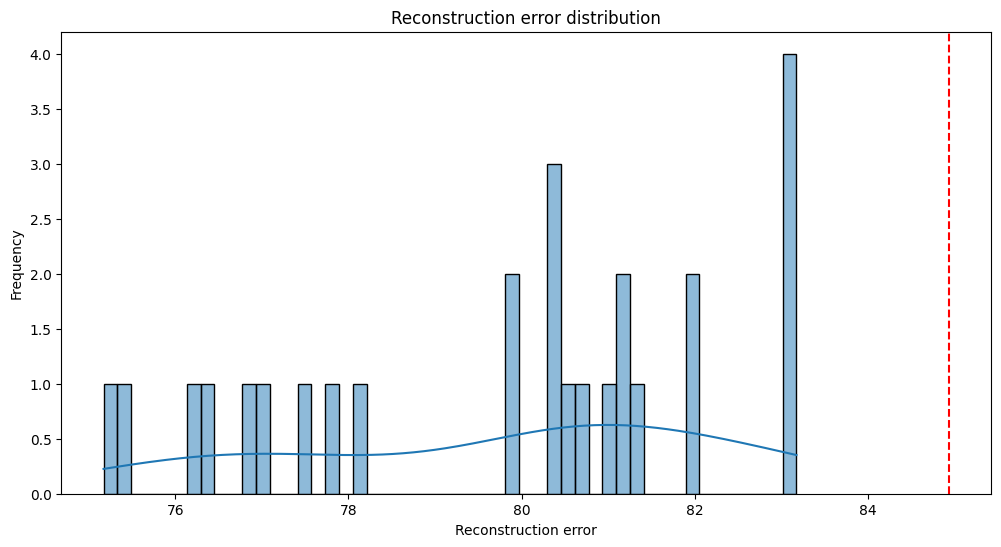

Anomaly threshold: 84.9372085954943


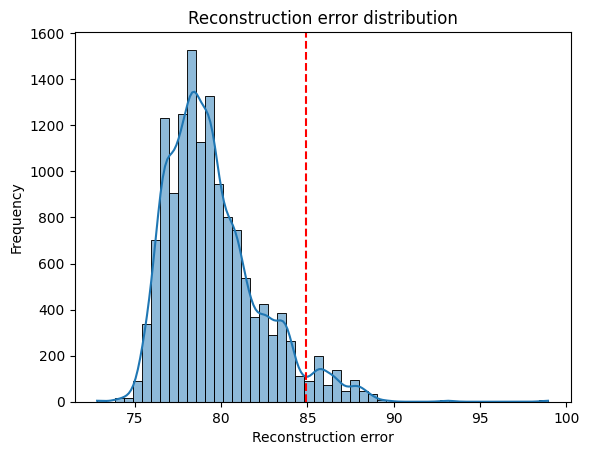

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(mse_test_df['reconstruction_error'], bins=50, kde=True)
plt.title('Reconstruction error distribution')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')


threshold = np.percentile(mse_train_df['reconstruction_error'], 95)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.show() 
print(f"Anomaly threshold: {threshold}")

sns.histplot(mse_train_df['reconstruction_error'], bins=50, kde=True)
plt.title('Reconstruction error distribution')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.show() 



Test new data for outliers

In [24]:
import pandas as pd
import numpy as np

# Set the file paths
folder_path = your_path + '6.Active Data/Test Data/'
# Get file in the folder
files = os.listdir(folder_path)
# MAC issue
files = [f for f in files if f != '.DS_Store']
file_name_test = files[0][:-4]

t_data_path = your_path + '3.Cash_Risk/' + file_name_test +'_Cash_Risk.csv' # THIS IS THE ORIGINAL TEST DATA 
t_data_scaled_path = your_path + '4.Scaled/' + file_name_test + '_Scaled.csv' # THIS IS THE SCALED TEST DATA

# Load new trade data from CSV (both processed and original)
t_data_scaled = pd.read_csv(t_data_scaled_path)
t_data = pd.read_csv(t_data_path)

# Convert data to float32
t_data_scaled = t_data_scaled.astype(np.float32)

# Check for inf or NaN values in data
print("Inf values in data: ", np.isinf(t_data_scaled).values.sum())
print("NaN values in data: ", np.isnan(t_data_scaled).values.sum())

# Check to make sure the data is in expected format
try:
    t_data_scaled = t_data_scaled.astype(float)
except ValueError as e:
    print(f"ValueError: {e}")


# Make sure the autoencoder variable is already defined and trained
# Predict with the autoencoder
new_predictions = autoencoder.predict(t_data_scaled)

# Measure the reconstruction error
new_mse = np.mean(np.power(t_data_scaled - new_predictions, 2), axis=1)
new_mse_df = pd.DataFrame({'reconstruction_error': new_mse})

# Determine whether each trade is an outlier or not
outlier_indices = new_mse_df[new_mse_df['reconstruction_error'] > threshold].index

# Filter the outlier trades from the original data using the outlier indices
outlier_trades_original = t_data.iloc[outlier_indices]

# Save the outlier trades to a CSV file in the original format
outlier_file_path = your_path + '5.Outliers/' + 'Outlier_IRS_test.csv'
outlier_trades_original.to_csv(outlier_file_path, index=False)

print('Number of outlier trades: '+str(len(outlier_trades_original)))
print('See trades in directory: '+outlier_file_path)


Inf values in data:  0
NaN values in data:  0
1/1 [==============================] - 0s 37ms/step
Number of outlier trades: 0
See trades in directory: /Users/elliotlindestam/Documents/Skola/Indek icloud/trioptima/5.Outliers/Outlier_IRS_test.csv
